# Verification Difference Graphs

In [1]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import xoak
import numpy as np
import matplotlib.pyplot as plt
import regionmask
import cartopy
import cartopy.crs as ccrs
import glob
%matplotlib inline
from copy import deepcopy

import warnings
warnings.filterwarnings('ignore')

In [2]:
def Data_Conv(ds):
    
    '''
    A defintion  
    
    Parameters
    ----------
    ds: xarray dataset
    
    Returns
    -------
    ds: returns a coarsened data with lat/long
    
    '''
    #load the geog file produce for WRF-BCC
    geog = xr.open_dataset("/home/scratch/WRF_BCC/geography/geo_em.d01.nc")
    geog = geog[['CLAT', 'CLONG']].coarsen(south_north=20, west_east=20, boundary='trim').mean()
    
    #coarsen the dataset to ~80-km
    ds = ds.coarsen(south_north=20, west_east=20, boundary='trim').sum()
    ds = xr.merge([ds, geog.squeeze()])
    ds = ds.rename({"CLONG": 'lon', 'CLAT': 'lat'})

    #assign lat/lon values of coarsen data and set index
    ds = ds.assign_coords({'x': ds.west_east, 'y': ds.south_north})
    ds = ds.assign_coords({'lon': ds.lon, 'lat': ds.lat})
    ds.xoak.set_index(['lat', 'lon'], 'sklearn_geo_balltree')
    
    return ds

In [3]:
#open dummy xarray dataset
ds = xr.open_dataset('/home/scratch/WRF_BCC/severe_weather/UP_HELI_MAX/historical/1990-1991/UP_HELI_MAX_historical-1990-1991_1990-10-01.nc').sel(Time='1990-10-01T00:00:00.000000000')
ds_copy = ds.copy()
ds_copy_cor = Data_Conv(ds_copy)

### Load the Dataframes

In [4]:
#load wrf-bcc dataset
df_UVV = pd.read_csv(f'/home/scratch/jcorner1/syn_sev/dataframes/HIST_UVV_REFC_regrid_threshold_dataframe.csv')
df_DVV = pd.read_csv(f'/home/scratch/jcorner1/syn_sev/dataframes/HIST_DVV_REFC_regrid_threshold_dataframe.csv')
df_UH = pd.read_csv(f'/home/scratch/jcorner1/syn_sev/dataframes/HIST_UH_REFC_regrid_threshold_dataframe.csv')

In [5]:
#load the SPC reports
#NOTE: These data have been regridded to the 80-km previously
df_tor = pd.read_csv(f'/home/scratch/jcorner1/syn_sev/dataframes/SPC_LSRs_regridded_tor_fix.csv')
df_hail = pd.read_csv(f'/home/scratch/jcorner1/syn_sev/dataframes/SPC_LSRs_regridded_hail_fix.csv')
df_wind = pd.read_csv(f'/home/scratch/jcorner1/syn_sev/dataframes/SPC_LSRs_regridded_wind_fix.csv')

### Iterate through Dataframe

In [6]:
#iterate through VAR and Z values for subsetting
df_DVV['DVV'] = np.absolute(df_DVV['DVV'].values)

#create a new dataframe
df_res_dvv = pd.DataFrame(columns=['DBZ', 'DVV', 'TOR_DIFF', 'WIND_DIFF', 'HAIL_DIFF'])

for refc in np.arange(40, 66, 5):
    for DVV in np.arange(5, 16, 1):
        
        #subset the dataframe based on current threshold values
        df_sub = df_DVV[((df_DVV['DBZ'] >= refc) & (df_DVV['DVV'] >= DVV))]
        
        df_res_dvv = df_res_dvv.append({'DBZ': refc, 'DVV': DVV, 'TOR_DIFF':len(df_tor) - len(df_sub),
                       'HAIL_DIFF':len(df_hail) - len(df_sub), 'WIND_DIFF':len(df_wind) - len(df_sub)}
                       , ignore_index=True)

In [7]:
#create a new dataframe
df_res_uvv = pd.DataFrame(columns=['DBZ', 'UVV', 'TOR_DIFF', 'WIND_DIFF', 'HAIL_DIFF'])

#iterate through VAR and Z values for subsetting
for refc in np.arange(40, 66, 5):
    for UVV in np.arange(18, 36, 1):
        
        #subset the dataframe based on current threshold values
        df_sub = df_UVV[((df_UVV['DBZ'] >= refc) & (df_UVV['UVV'] >= UVV))]
        
        df_res_uvv = df_res_uvv.append({'DBZ': refc, 'UVV': UVV, 'TOR_DIFF':len(df_tor) - len(df_sub),
                       'HAIL_DIFF':len(df_hail) - len(df_sub), 'WIND_DIFF':len(df_wind) - len(df_sub)}
                       , ignore_index=True)

In [8]:
#create a new dataframe
df_res_uh = pd.DataFrame(columns=['DBZ', 'UH', 'TOR_DIFF', 'WIND_DIFF', 'HAIL_DIFF'])


#iterate through VAR and Z values for subsetting
for refc in np.arange(40, 66, 5):
    for UH in np.arange(35, 150, 5):
        
        #subset the dataframe based on current threshold values
        df_sub = df_UH[((df_UH['DBZ'] >= refc) & (df_UH['UH'] >= UH))]
        
        df_res_uh = df_res_uh.append({'DBZ': refc, 'UH': UH, 'TOR_DIFF':len(df_tor) - len(df_sub),
                       'HAIL_DIFF':len(df_hail) - len(df_sub), 'WIND_DIFF':len(df_wind) - len(df_sub)}
                       , ignore_index=True)

### Create Graphs

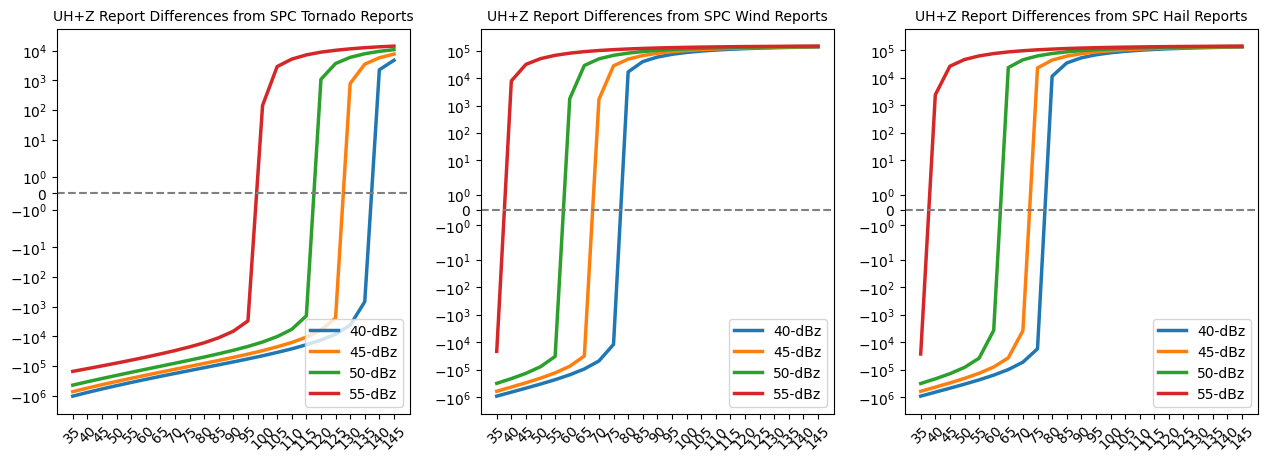

In [9]:
hazs = ['TOR', 'WIND', 'HAIL']
hazards = ['Tornado', 'Wind', 'Hail']

plt.figure(figsize=(15.5,5))

#iterate through the hazards
for haz in range(len(hazs)):
    
    #iterate through vars
    ax = plt.subplot(1,3,haz+1)
    
    #iterate through each reflectivty value
    for i in range(40, 56, 5):
        df = df_res_uh[(df_res_uh['DBZ'] == i)]
        plt.plot(np.arange(35, 150, 5), df[f'{hazs[haz]}_DIFF'].values, lw=2.5)
        plt.title(f'UH+Z Report Differences from SPC {hazards[haz]} Reports',fontsize=10)
        plt.yscale('symlog')
        plt.xticks(ticks = np.arange(35, 150, 5), labels = np.arange(35, 150, 5), rotation=45)
        plt.legend([x + '-dBz' for x in list(map(str, np.arange(40, 56, 5)))], loc ='lower right').set_zorder(12)
        
    plt.axhline(y = 0.0, color = 'grey', ls='--')


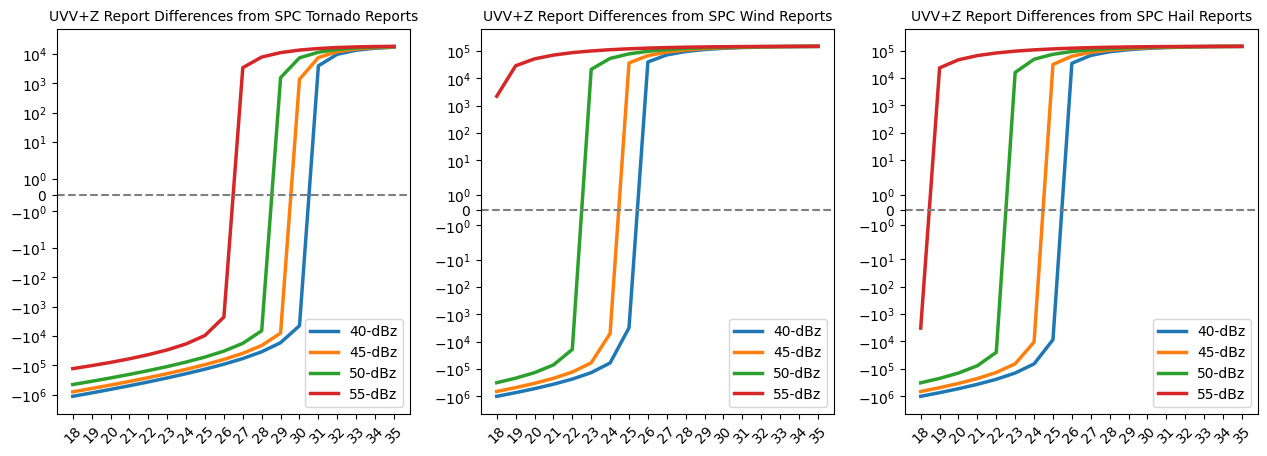

In [10]:
hazs = ['TOR', 'WIND', 'HAIL']
hazards = ['Tornado', 'Wind', 'Hail']

plt.figure(figsize=(15.5,5))

#iterate through the hazards
for haz in range(len(hazs)):
    
    #iterate through vars
    ax = plt.subplot(1,3,haz+1)
    
    #iterate through each reflectivty value
    for i in range(40, 56, 5):
        df = df_res_uvv[(df_res_uvv['DBZ'] == i)]
        plt.plot(np.arange(18, 36, 1), df[f'{hazs[haz]}_DIFF'].values, lw=2.5)
        plt.title(f'UVV+Z Report Differences from SPC {hazards[haz]} Reports',fontsize=10)
        plt.yscale('symlog')
        plt.xticks(ticks = np.arange(18, 36, 1), labels = np.arange(18, 36, 1), rotation=45)
        plt.legend([x + '-dBz' for x in list(map(str, np.arange(40, 56, 5)))], loc ='lower right').set_zorder(12)
        
    plt.axhline(y = 0.0, color = 'grey', ls='--')


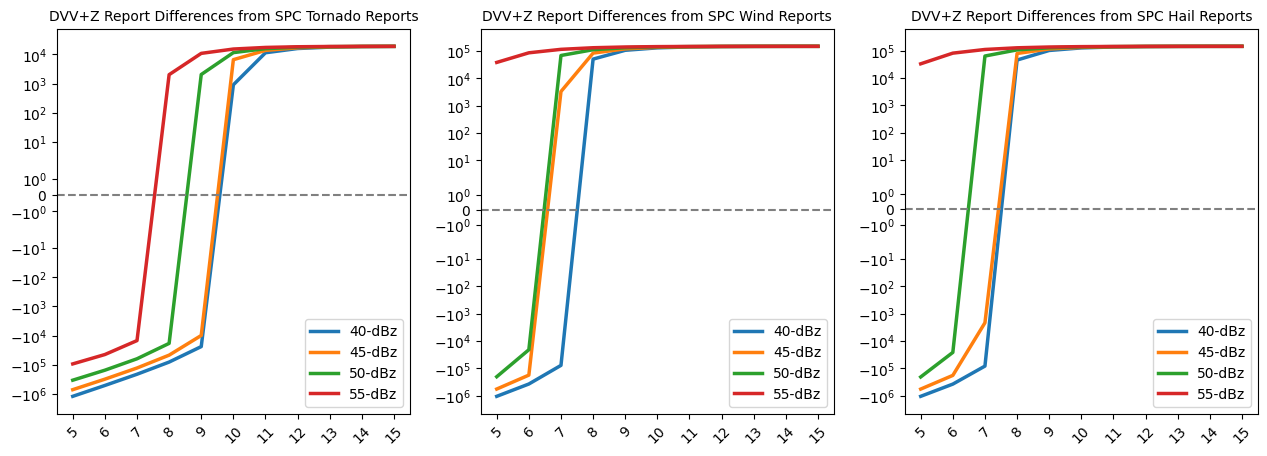

In [11]:
hazs = ['TOR', 'WIND', 'HAIL']
hazards = ['Tornado', 'Wind', 'Hail']

plt.figure(figsize=(15.5,5))

#iterate through the hazards
for haz in range(len(hazs)):
    
    #iterate through vars
    ax = plt.subplot(1,3,haz+1)
    
    #iterate through each reflectivty value
    for i in range(40, 56, 5):
        df = df_res_dvv[(df_res_dvv['DBZ'] == i)]
        plt.plot(np.arange(5, 16, 1), df[f'{hazs[haz]}_DIFF'].values, lw=2.5)
        plt.title(f'DVV+Z Report Differences from SPC {hazards[haz]} Reports',fontsize=10)
        plt.xticks(ticks = np.arange(5, 16, 1), labels = np.arange(5, 16, 1), rotation=45)
        plt.yscale('symlog')
        plt.legend([x + '-dBz' for x in list(map(str, np.arange(40, 56, 5)))], loc ='lower right').set_zorder(12)
        
    plt.axhline(y = 0.0, color = 'grey', ls='--')


In [12]:
df_res_uvv[(df_res_uvv['DBZ'] == 40)]

,DBZ,UVV,TOR_DIFF,WIND_DIFF,HAIL_DIFF
0,40,18,-1130615,-1000085,-1005546
1,40,19,-864585,-734055,-739516
2,40,20,-654996,-524466,-529927
3,40,21,-491911,-361381,-366842
4,40,22,-364725,-234195,-239656
5,40,23,-266717,-136187,-141648
6,40,24,-190988,-60458,-65919
7,40,25,-133671,-3141,-8602
8,40,26,-90629,39901,34440
9,40,27,-58224,72306,66845


In [13]:
df_res_uh[(df_res_uh['DBZ'] == 40)]

,DBZ,UH,TOR_DIFF,WIND_DIFF,HAIL_DIFF
0,40,35,-1034020,-903490,-908951
1,40,40,-776809,-646279,-651740
2,40,45,-593202,-462672,-468133
3,40,50,-458635,-328105,-333566
4,40,55,-358013,-227483,-232944
5,40,60,-281778,-151248,-156709
6,40,65,-223292,-92762,-98223
7,40,70,-177987,-47457,-52918
8,40,75,-142354,-11824,-17285
9,40,80,-113906,16624,11163
